In [58]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from netgraph import Graph
import statistics
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD

In [15]:
D_data = pd.read_csv('data/Denmark/Merged.csv')
USA_data = pd.read_csv('data/USA/filtered_USA_votes.csv')

In [16]:
D_data['opdateringsdato_x'] = pd.to_datetime(D_data['opdateringsdato_x'],errors='coerce')

start_date = "2022-12-01"
end_date = "2025-12-31"

D_data = D_data[(D_data['opdateringsdato_x'] >= start_date) & (D_data['opdateringsdato_x'] <= end_date)]

In [17]:
D_data

,Unnamed: 0,typeid_x,afstemningid,aktørid,opdateringsdato_x,id_y,typeid_y,navn,opdateringsdato_y,startdato,slutdato,party
1672,1672,1,9004,49,2022-12-13 13:01:44.197,49,5,Erling Bonnesen,2025-02-03T09:39:35.91,2024-10-01T00:00:00,NaN,Venstre
1673,1673,1,9014,49,2022-12-22 09:42:26.073,49,5,Erling Bonnesen,2025-02-03T09:39:35.91,2024-10-01T00:00:00,NaN,Venstre
1674,1674,1,9015,49,2022-12-22 09:43:02.663,49,5,Erling Bonnesen,2025-02-03T09:39:35.91,2024-10-01T00:00:00,NaN,Venstre
1675,1675,1,9016,49,2022-12-22 09:44:07.067,49,5,Erling Bonnesen,2025-02-03T09:39:35.91,2024-10-01T00:00:00,NaN,Venstre
1676,1676,1,9017,49,2022-12-22 09:45:39.340,49,5,Erling Bonnesen,2025-02-03T09:39:35.91,2024-10-01T00:00:00,NaN,Venstre
...,...,...,...,...,...,...,...,...,...,...,...,...
302093,302093,1,10110,21044,2025-01-16 17:00:16.147,21044,5,Lasse Haugaard Pedersen,2025-02-03T09:39:35.91,2024-12-01T00:00:00,NaN,Socialdemokratiet
302094,302094,1,10111,21044,2025-01-23 10:01:05.520,21044,5,Lasse Haugaard Pedersen,2025-02-03T09:39:35.91,2024-12-01T00:00:00,NaN,Socialdemokratiet
302095,302095,1,10112,21044,2025-01-23 10:01:33.953,21044,5,Lasse Haugaard Pedersen,2025-02-03T09:39:35.91,2024-12-01T00:00:00,NaN,Socialdemokratiet
302096,302096,1,10113,21044,2025-01-23 10:02:11.817,21044,5,Lasse Haugaard Pedersen,2025-02-03T09:39:35.91,2024-12-01T00:00:00,NaN,Socialdemokratiet


In [18]:
#we check both ways, we calc both i -> j and j->i.
# person 221 as i and 1619 as j, and the other way. 1619 as i and 221 as j. is that a problem? 
#there are prob some variables that needs renaming

def calc_thres(PP, PA, PAV):
    party_agree = []
    for party in PP:
        #print(party)
        memb_agree = []
        for member1 in PP.get(party):
            for member2 in set(PP.get(party)):
                if member1 != member2:
                    common = set(PAV.get(member1)) & set(PAV.get(member2)) # how many votes do they agree on 
                
                    common2 = set(PA.get(member1)) & set(PA.get(member2)) # how many same bills have they voted on

                    if len(common) != 0: # if they have at least one vote thats the same, (too avoid divide by 0)
                    
                        percentage = len(common) / len(common2)
                        memb_agree.append(percentage)
                    else:
                        memb_agree.append(0)
        if len(memb_agree) != 0:
            avgMemb = sum(memb_agree)/len(memb_agree)
            #std_dev = statistics.stdev(memb_agree) if len(memb_agree) > 1 else 0  # Avoid error for single-member case
            avg_plus_std = avgMemb# + std_dev # Compute the sum of average and standard deviation
            party_agree.append(avg_plus_std)
            #print(avg_plus_std)
        #else:
            #print(party) # party where there is only one member
            #print('1')
            #party_agree.append(1)
    avgParty = np.percentile(party_agree, 75)
    #avgParty = sum(party_agree)/len(party_agree)
    #print(max(party_agree))
    return avgParty


In [19]:
def edgelist_calc(PA, PAV, threshold):
    edgelist=[]
    for i in PAV: # person 1

        for j in PAV: # for loop for person 2

            if i != j: # checks they are not the same

                common = set(PAV.get(i)) & set(PAV.get(j)) # how many votes do they agree on 
                
                common2 = set(PA.get(i)) & set(PA.get(j)) # how many same bills have they voted on

                if len(common) != 0: # if they have at least one vote thats the same, (too avoid divide by 0)
                    
                    percentage = len(common) / len(common2)
                    if percentage > threshold:
                        edgelist.append((i,j))
                

    return list(set(edgelist))
    

In [35]:
def calc_inter_edges(PP, PA, PAV):
    inter_party_agree = []  # Stores agreement percentages for different-party members
    parties = list(PP.keys())  # Get the list of parties

    # Take all possible member combinations between the two parties
    party1, party2 = parties[0], parties[1]

    for member1 in PP.get(party1, []):  # Iterate over members of Party 1
        for member2 in PP.get(party2, []):  # Iterate over members of Party 2
            common = set(PAV.get(member1, [])) & set(PAV.get(member2, []))  # Common votes
            common2 = set(PA.get(member1, [])) & set(PA.get(member2, []))  # Common bills

            if len(common) != 0 :  # Avoid division by zero
                percentage = len(common) / len(common2)
                inter_party_agree.append((member1, member2, percentage))
    max_percentage = max(inter_party_agree, key=lambda x: x[2])[2]

    # Get all (member1, member2) pairs with the max percentage
    edgelist = [(m1, m2) for m1, m2, perc in inter_party_agree if perc == max_percentage]

    return edgelist   


In [7]:
#----------------------------------------------------------------------------------------------------------------#
#----------------------------------------DENMARK-----------------------------------------------------------------#
#----------------------------------------------------------------------------------------------------------------#

In [20]:
#dict, key = id, values = (afstemningid, typeid)
# dict of all people with all their votes (voting id and what they voted)

PA = {}          #<<-------------- Person, Afstemning
for idx, row in D_data.iterrows():
    if row['aktørid'] not in PA:
        PA[row['aktørid']] = [(row['afstemningid'])]
    else:
        PA[row['aktørid']].append((row['afstemningid']))

PAV = {}          #<<-------------- Person, Afstemning, Vote
for idx, row in D_data.iterrows():
    if row['aktørid'] not in PAV:
        PAV[row['aktørid']] = [(row['afstemningid'],row['typeid_x'])]
    else:
        PAV[row['aktørid']].append((row['afstemningid'],row['typeid_x']))


PAVP = {}          #<<-------------- Person, Afstemning, Vote, Party
for idx, row in D_data.iterrows():
    if row['aktørid'] not in PAVP:
        PAVP[row['aktørid']] = [(row['afstemningid'],row['typeid_x'],row['party'],row['navn'])]
    else:
        PAVP[row['aktørid']].append((row['afstemningid'],row['typeid_x'],row['party'],row['navn']))
 
#dict of parties with memberid as values

PP = {}          #<<-------------- Party, Person
for idx, row in D_data.iterrows():
    if row['party'] not in PP:
        PP[row['party']] = [(row['aktørid'])]
    elif row['aktørid'] not in PP.get(row['party']):
        PP[row['party']].append((row['aktørid']))


In [21]:
D_thres = calc_thres(PP,PA,PAV)
D_thres

0.9227807271355366

In [54]:
edgelist = edgelist_calc(PA,PAV, D_thres)
df = pd.DataFrame(edgelist, columns=["Source", "Target"])
df.to_csv("Denmark_edgelist.csv", index=False)
G_denmark = nx.from_edgelist(edgelist)

In [45]:
len(edgelist)

13322

In [24]:
list_of_dangle = [node for node in G_denmark.nodes if G_denmark.degree(node) == 0]
list_of_dangle

[]

In [13]:
#----------------------------------------------------------------------------------------------------------------#
#------------------------------------------USA-------------------------------------------------------------------#
#----------------------------------------------------------------------------------------------------------------#


In [25]:
U_PA = {}          #<<-------------- Person, Afstemning
for idx, row in USA_data.iterrows():
    if row['congress'] == 118:
        if row['icpsr'] not in U_PA:
            U_PA[row['icpsr']] = [(row['rollnumber'])]
        else:
            U_PA[row['icpsr']].append((row['rollnumber']))

U_PAV = {}          #<<-------------- Person, Afstemning, Vote
for idx, row in USA_data.iterrows():
    if row['congress'] == 118:
        if row['icpsr'] not in U_PAV:
            U_PAV[row['icpsr']] = [(row['rollnumber'],row['cast_code'])]
        else:
            U_PAV[row['icpsr']].append((row['rollnumber'],row['cast_code']))


U_PAVP = {}          #<<-------------- Person, Afstemning, Vote, Party
for idx, row in USA_data.iterrows():
    if row['congress'] == 118:
        if row['icpsr'] not in U_PAVP:
            U_PAVP[row['icpsr']] = [(row['rollnumber'],row['cast_code'],row['party_code'])]
        else:
            U_PAVP[row['icpsr']].append((row['rollnumber'],row['cast_code'],row['party_code']))

#dict of parties with memberid as values

U_PP = {}          #<<-------------- Party, Person
for idx, row in USA_data.iterrows():
    if row['congress'] == 118:
        if row['party_code'] not in U_PP:
            U_PP[row['party_code']] = [(row['icpsr'])]
        elif row['icpsr'] not in U_PP.get(row['party_code']):
            U_PP[row['party_code']].append((row['icpsr']))

In [26]:
U_thres = calc_thres(U_PP, U_PA, U_PAV)

In [39]:
USA_inter= calc_inter_edges(U_PP,U_PA,U_PAV)

In [53]:
U_edgelist = edgelist_calc(U_PA, U_PAV, U_thres)
U_edgelist = (U_edgelist + USA_inter)
df = pd.DataFrame(U_edgelist, columns=["Source", "Target"])
df.to_csv("USA_edgelist.csv", index=False)
G_USA = nx.from_edgelist(U_edgelist)

In [47]:
list_of_dangle = [node for node in G_USA.nodes if G_USA.degree(node) == 0]
list_of_dangle

[]

76572

In [48]:
# Create node to community mapping based on party codes
node_to_community = {}
party_to_community = {
    100: 0,  # Democrat
    200: 1,  # Republican 
    328: 2,  # Independent
}

for icpsr in U_PAVP:
    party_code = U_PAVP[icpsr][0][2]  # Get party code from first vote
    node_to_community[icpsr] = party_to_community.get(party_code, 3)  # Default 3 for other parties

# Color mapping
community_to_color = {
    0: 'blue',      # Democrats
    1: 'red',       # Republicans
    2: 'green',     # Independents
    3: 'gray'       # Others
}
node_color = {node: community_to_color[community_id] 
              for node, community_id in node_to_community.items()}



c:\Users\kubic\OneDrive\Dokumenty\lib\site-packages\netgraph\_utils.py:360: RuntimeWarning: invalid value encountered in divide
  v = v / np.linalg.norm(v, axis=-1)[:, None] # unit vector


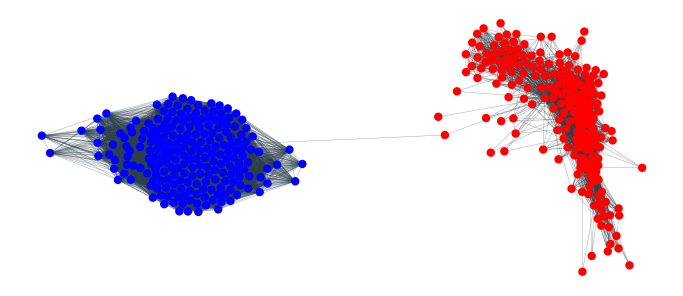

In [49]:
# Visualization
fig, ax = plt.subplots(figsize=(12, 8))
Graph(G_USA,
      node_color=node_color,
      node_edge_width=0,
      node_size=1,
      edge_width=0.1,
      edge_alpha=0.5,
      node_layout='community', 
      node_layout_kwargs=dict(node_to_community=node_to_community),
      ax=ax)
plt.show()

In [50]:
set(D_data['party'])

{'Alternativet',
 'Borgernes Parti',
 'Danmarksdemokraterne',
 'Dansk Folkeparti',
 'Det Konservative Folkeparti',
 'Enhedslisten',
 'Liberal Alliance',
 'Moderaterne',
 'Radikale Venstre',
 'Sambandsflokkurin',
 'Siumut',
 'Socialdemokratiet',
 'Socialistisk Folkeparti',
 'Uden for folketingsgrupperne',
 'Venstre'}

In [51]:
# Create node to community mapping based on party codes
node_to_community = {}
party_to_community = {
    'Alternativet': 0,  
    'Danmarksdemokraterne': 1,   
    'Dansk Folkeparti': 2,
    'Det Konservative Folkeparti': 3,
    'Enhedslisten': 4,
    'Frie Grønne': 5,
    'Liberal Alliance': 6,
    'Moderaterne': 7,
    'Radikale Venstre': 8,
    'Sambandsflokkurin': 9,
    'Siumut': 10,
    'Socialdemokratiet': 11,
    'Socialistisk Folkeparti': 12,
    'Uden for folketingsgrupperne': 13,
    'Venstre': 14,
     

}

# Color mapping
community_to_color = {
   0: 'green',
   1: 'lightblue', 
   2: 'yellow',
   3: 'darkgreen',
   4: 'orange',
   5: 'cyan',
   6: 'blue',
   7: 'magenta',
   8: 'purple',
   9: 'black',
   10: 'gray',
   11: 'red',
   12: 'pink',
   13: 'brown',
   14: 'navy'
}

node_to_community = {}
for aktor_id in PAVP:
   party_name = PAVP[aktor_id][0][2]  # Get party name from first vote
   node_to_community[aktor_id] = party_to_community.get(party_name, 0)

node_color = {node: community_to_color[community_id] 
              for node, community_id in node_to_community.items()}

c:\Users\kubic\OneDrive\Dokumenty\lib\site-packages\netgraph\_node_layout.py:1621: UserWarning: There are no connections within community 13. The placement of of nodes within this community is arbitrary.
  warnings.warn(f"There are no connections within community {community}. The placement of of nodes within this community is arbitrary.")
c:\Users\kubic\OneDrive\Dokumenty\lib\site-packages\netgraph\_node_layout.py:1024: RuntimeWarning: invalid value encountered in divide
  directions = deltas / magnitudes[:, np.newaxis]


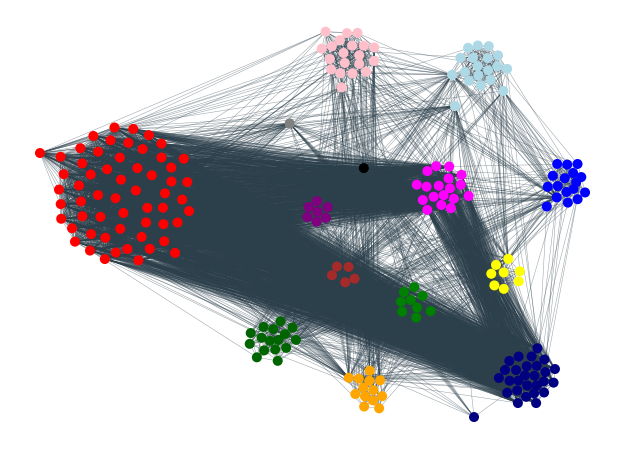

In [52]:
fig, ax = plt.subplots(figsize=(12, 8))
Graph(G_denmark,
      node_color=node_color,
      node_edge_width=0,
      node_size=1,
      edge_width=0.1,
      edge_alpha=0.5,
      node_layout='community', 
      node_layout_kwargs=dict(node_to_community=node_to_community),
      ax=ax)
plt.show()

In [ ]:
# Step 1: Create a list of people (rows) and their corresponding voted bills (columns)
people = list(PAV.keys())  # List of people (1, 2, 3, 4)
votes = set()  # Store the distinct votes/bills
for person in PAV:
    votes.update(PAV[person])  # Add all the bills that each person voted on

votes = sorted(votes)  # Sort the bills to get a consistent column order
vote_to_index = {vote: idx for idx, vote in enumerate(votes)}  # Mapping from bill to column index

# Step 2: Construct the data for the sparse matrix
data = []
row_indices = []
col_indices = []

for person, voted_bills in PAV.items():
    for bill in voted_bills:
        row_indices.append(people.index(person))  # Person's row index
        col_indices.append(vote_to_index[bill])   # Bill's column index
        data.append(1)  # The value in the matrix is 1 if the person voted on the bill

# Step 3: Create the sparse matrix (CSR format)
num_people = len(PAV)  # Number of people
num_votes = len(votes)  # Number of bills
sparse_matrix = csr_matrix((data, (row_indices, col_indices)), shape=(num_people, num_votes))



Dense Matrix Representation:
  (0, 0)	1
  (0, 15)	1
  (0, 17)	1
  (0, 19)	1
  (0, 20)	1
  (0, 29)	1
  (0, 34)	1
  (0, 36)	1
  (0, 40)	1
  (0, 41)	1
  (0, 44)	1
  (0, 45)	1
  (0, 46)	1
  (0, 47)	1
  (0, 48)	1
  (0, 50)	1
  (0, 52)	1
  (0, 54)	1
  (0, 55)	1
  (0, 57)	1
  (0, 58)	1
  (0, 60)	1
  (0, 61)	1
  (0, 62)	1
  (0, 64)	1
  :	:
  (219, 1890)	1
  (219, 1893)	1
  (219, 1895)	1
  (219, 1897)	1
  (219, 1899)	1
  (219, 1901)	1
  (219, 1903)	1
  (219, 1905)	1
  (219, 1907)	1
  (219, 1909)	1
  (219, 1911)	1
  (219, 1913)	1
  (219, 1915)	1
  (219, 1917)	1
  (219, 1919)	1
  (219, 1920)	1
  (219, 1922)	1
  (219, 1924)	1
  (219, 1926)	1
  (219, 1927)	1
  (219, 1928)	1
  (219, 1930)	1
  (219, 1932)	1
  (219, 1934)	1
  (219, 1937)	1


In [59]:
# Step 2: Apply TruncatedSVD (PCA for sparse matrix)
n_components = 2  # You can set the number of components (dimensions) to reduce to
svd = TruncatedSVD(n_components=n_components)
reduced_matrix = svd.fit_transform(sparse_matrix)

# Step 3: Display the reduced matrix (lower dimensions)
print("Reduced Matrix (PCA Result):")
print(reduced_matrix)

# Optional: You can also check the amount of variance explained by each component
print("Explained variance ratio:")
print(svd.explained_variance_ratio_)

Reduced Matrix (PCA Result):
[[ 2.63052792e+01 -5.08875878e+00]
 [ 1.89655855e+01 -4.90352400e+00]
 [ 2.13069149e+01 -4.03688089e+00]
 [ 3.98139732e-01  1.40175255e-01]
 [ 1.41138670e+01  9.61973458e+00]
 [ 1.16854529e+01 -1.22293675e+00]
 [ 3.63213157e+00 -1.21883097e+00]
 [ 1.60599637e+01 -3.00197433e+00]
 [ 2.45185316e+01 -6.30664147e+00]
 [ 2.40334231e+01 -5.06701244e+00]
 [ 1.99270066e+01 -2.40295875e+00]
 [ 2.07357538e+01 -5.10135091e+00]
 [ 1.75233637e+01  1.26695055e+01]
 [ 2.45490807e+00 -1.12668331e-01]
 [ 2.44931793e+01 -5.68233553e+00]
 [ 1.89015899e+01  1.44817073e+01]
 [ 2.73712378e+01 -6.17977040e+00]
 [ 2.63526863e+01 -4.33925740e+00]
 [ 1.76839387e+01  1.43855058e+01]
 [ 1.09311761e+01 -2.92673873e+00]
 [ 1.36805694e+01  1.08995393e+01]
 [ 1.32306781e+01 -5.63698494e+00]
 [ 2.77392134e+01 -6.32721611e+00]
 [ 2.23664780e+01 -4.49595606e+00]
 [ 2.13424504e+01 -4.20315796e+00]
 [ 2.30454305e+01 -5.77482275e+00]
 [ 1.30673020e+01 -6.90448496e-01]
 [ 7.50318436e+00  2.75367

In [64]:
import umap
umap_model = umap.UMAP(n_components=2, random_state=42)  # 2D UMAP
umap_result = umap_model.fit_transform(reduced_matrix)

# Step 3: Visualize UMAP results
plt.figure(figsize=(8, 6))
plt.scatter(umap_result[:, 0], umap_result[:, 1], c='blue', label="UMAP Projection")
plt.title("UMAP Projection After PCA")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.legend()
plt.show()

AttributeError: module 'umap' has no attribute 'UMAP'